In [2]:
# Import statements
import numpy as np 
import pandas as pd
import datetime
import matplotlib.pyplot as plt
import warnings
import itertools
import statsmodels.api as sm
import seaborn as sns
import math
from pylab import rcParams
from sklearn.preprocessing import MinMaxScaler

#Jupyter Notebook Specific
sns.set_context("paper", font_scale=1.3)
sns.set_style('white')
warnings.filterwarnings("ignore")
plt.style.use('fivethirtyeight')

In [3]:
import os, types
import pandas as pd
from botocore.client import Config
import ibm_boto3

def __iter__(self): return 0

# @hidden_cell
# The following code accesses a file in your IBM Cloud Object Storage. It includes your credentials.
# You might want to remove those credentials before you share the notebook.
cos_client = ibm_boto3.client(service_name='s3',
    ibm_api_key_id='jxEP1bzVWo0XmoQGhCkfcFTMUvezzzWxvUmiPIDP9Y5F',
    ibm_auth_endpoint="https://iam.cloud.ibm.com/oidc/token",
    config=Config(signature_version='oauth'),
    endpoint_url='https://s3.private.us.cloud-object-storage.appdomain.cloud')

bucket = 'crudeoilpriceprediction-donotdelete-pr-ekltddoz8wv161'
object_key = 'Crude Oil Prices Daily.xlsx'

body = cos_client.get_object(Bucket=bucket,Key=object_key)['Body']

df_data_0 = pd.read_excel(body.read())
df_data_0['Date']=pd.to_datetime(df_data_0['Date'])

In [4]:
df_data_0.isnull().any()

Date             False
Closing Value     True
dtype: bool

In [5]:
df_data_0.dropna(axis=0,inplace=True)

In [6]:
data_oil = df_data_0.reset_index()['Closing Value']

In [7]:
len(data_oil)

8216

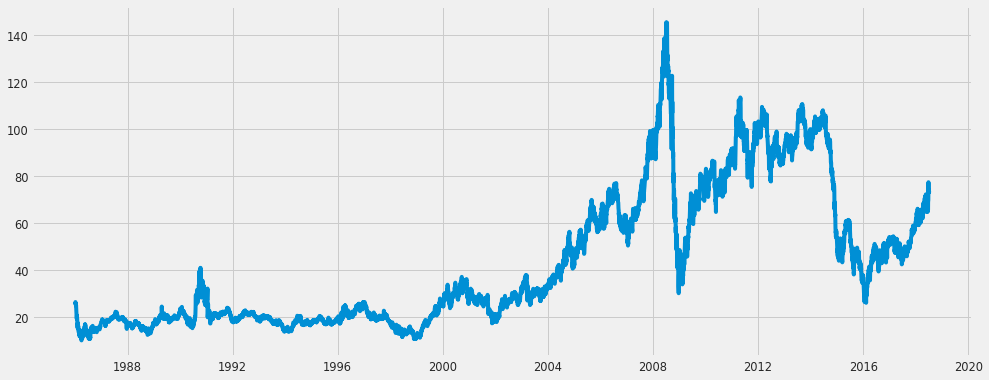

In [9]:
plt_1 = plt.figure(figsize=(15, 6))
time = pd.to_datetime(df_data_0['Date'])
data = list(df_data_0['Closing Value'])
copdata = pd.Series(data, time)
plt.plot(copdata)

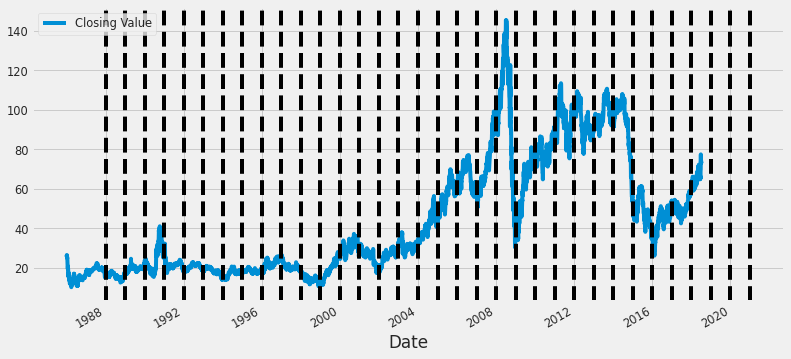

In [10]:
#observe for any seasonal patterns
ax = df_data_0.plot(x='Date', y='Closing Value', figsize=(12,6))
xcoords = ['1988-01-01','1989-01-01','1990-01-01','1991-01-01','1992-01-01','1993-01-01','1994-01-01',
           '1995-01-01','1996-01-01','1997-01-01','1998-01-01','1999-01-01','2000-01-01','2001-01-01',
           '2002-01-01','2003-01-01','2004-01-01','2005-01-01','2006-01-01','2007-01-01','2008-01-01',
           '2009-01-01','2010-01-01','2011-01-01','2012-01-01','2013-01-01','2014-01-01','2015-01-01',
           '2016-01-01','2017-01-01', '2018-01-01', '2019-01-01', '2020-01-01','2021-01-01']
for xc in xcoords:
    plt.axvline(x=xc, color='black', linestyle='--')

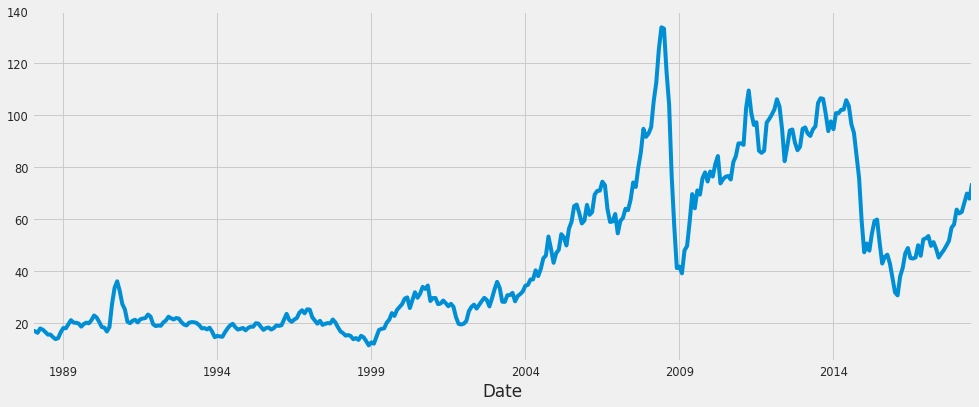

In [12]:
#Decompose the plot
df1 = df_data_0
df1 = df1.sort_values('Date')
df1 = df1.groupby('Date')['Closing Value'].sum().reset_index()
df1.set_index('Date', inplace=True)
df1=df1.loc[datetime.date(year=1988,month=1,day=1):]

q = df1['Closing Value'].resample('MS').mean()
q.plot(figsize=(15, 6))
plt.show()

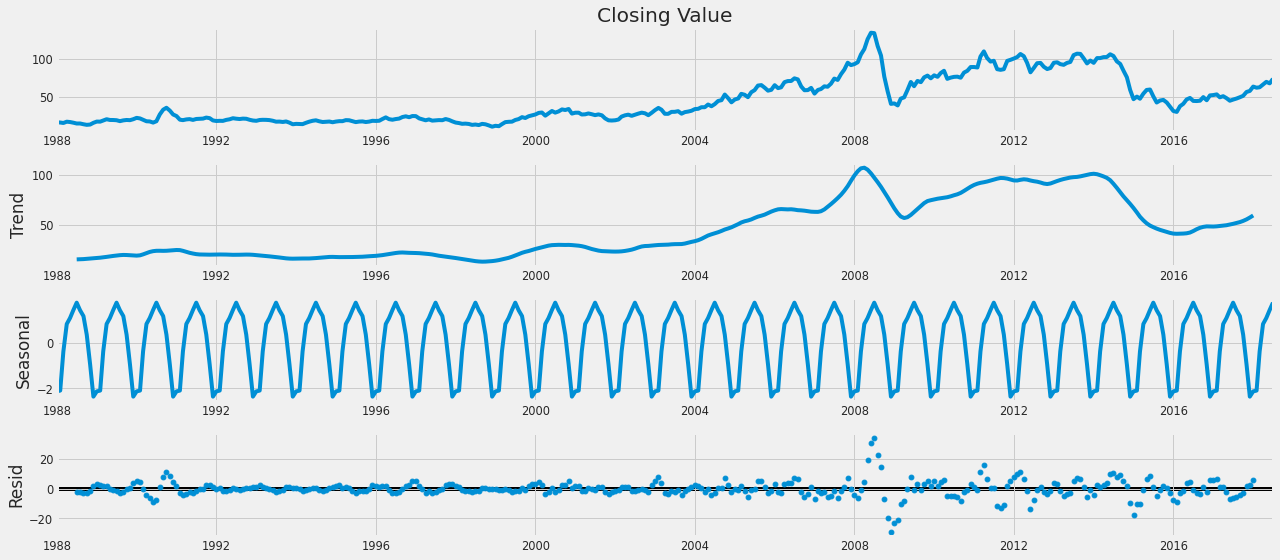

In [13]:
rcParams['figure.figsize'] = 18, 8
decomposition = sm.tsa.seasonal_decompose(q, model='additive')
fig = decomposition.plot()
plt.show()

In [14]:
sc = MinMaxScaler(feature_range = (0, 1))
data_oil = sc.fit_transform(np.array(data_oil).reshape(-1,1))

In [15]:
len(data_oil)

8216

In [16]:
train_size = int(len(data_oil) * 0.65)
test_size = len(data_oil) - train_size
train, test = data_oil[0:train_size, :], data_oil[train_size:len(data_oil), :]

In [17]:
len(test)

2876

In [18]:
def create_dataset(_data_set, _look_back=1):
    data_x, data_y = [], []
    for i in range(len(_data_set) - _look_back - 1):
        a = _data_set[i:(i + _look_back), 0]
        data_x.append(a)
        data_y.append(_data_set[i + _look_back, 0])
    return np.array(data_x), np.array(data_y)


time_step = 10
X_train , Y_train = create_dataset(train,time_step)
X_test , Y_test = create_dataset(test,time_step)

X_train = X_train.reshape(X_train.shape[0],X_train.shape[1],1)
X_test = X_test.reshape(X_test.shape[0],X_test.shape[1],1)

In [19]:
X_train.shape

(5329, 10, 1)

In [20]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
from sklearn.metrics import mean_squared_error
from keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error

In [21]:
regressor = Sequential()
regressor.add(LSTM(units = 60, return_sequences = True, input_shape = (X_train.shape[1], 1)))
regressor.add(Dropout(0.1))

regressor.add(LSTM(units = 60, return_sequences = True))
regressor.add(Dropout(0.1))

regressor.add(LSTM(units = 60))
regressor.add(Dropout(0.1))

regressor.add(Dense(units = 1))

regressor.compile(optimizer = 'adam', loss = 'mean_squared_error')
# early_stopping = EarlyStopping(monitor='val_loss',patience=20)
history =regressor.fit(X_train, Y_train, epochs = 20, batch_size = 64,validation_data=(X_test, Y_test),verbose=1)
# history =regressor.fit(X_train, Y_train, epochs = 100, batch_size = 64,validation_data=(X_test, Y_test)

Epoch 1/20
84/84 [==============================] - 5s 22ms/step - loss: 0.0016 - val_loss: 0.0018
Epoch 2/20
84/84 [==============================] - 1s 14ms/step - loss: 2.2518e-04 - val_loss: 7.3368e-04
Epoch 3/20
84/84 [==============================] - 1s 16ms/step - loss: 2.0074e-04 - val_loss: 7.3821e-04
Epoch 4/20
84/84 [==============================] - 1s 14ms/step - loss: 1.9867e-04 - val_loss: 7.6358e-04
Epoch 5/20
84/84 [==============================] - 1s 14ms/step - loss: 1.9252e-04 - val_loss: 0.0010
Epoch 6/20
84/84 [==============================] - 1s 14ms/step - loss: 1.9391e-04 - val_loss: 7.7598e-04
Epoch 7/20
84/84 [==============================] - 1s 15ms/step - loss: 2.0522e-04 - val_loss: 6.7660e-04
Epoch 8/20
84/84 [==============================] - 2s 20ms/step - loss: 1.9437e-04 - val_loss: 6.8141e-04
Epoch 9/20
84/84 [==============================] - 1s 16ms/step - loss: 1.7695e-04 - val_loss: 8.4088e-04
Epoch 10/20
84/84 [==============================

In [22]:
train_predict = regressor.predict(X_train)
test_predict = regressor.predict(X_test)

In [23]:
# invert predictions
train_predict = sc.inverse_transform(train_predict)
Y_train = sc.inverse_transform([Y_train])
test_predict = sc.inverse_transform(test_predict)
Y_test = sc.inverse_transform([Y_test])

Train Mean Absolute Error: 0.8082561245454949
Train Root Mean Squared Error: 1.205364160453239
Test Mean Absolute Error: 2.1252786170200526
Test Root Mean Squared Error: 2.873785434361081


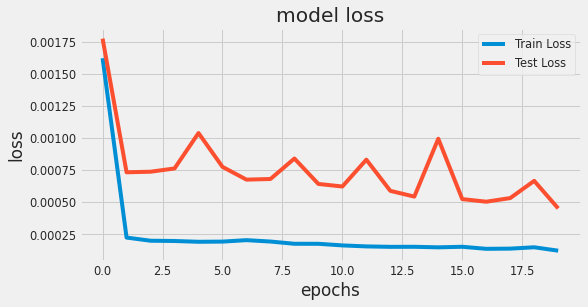

In [24]:
print('Train Mean Absolute Error:', mean_absolute_error(Y_train[0], train_predict[:,0]))
print('Train Root Mean Squared Error:',np.sqrt(mean_squared_error(Y_train[0], train_predict[:,0])))
print('Test Mean Absolute Error:', mean_absolute_error(Y_test[0], test_predict[:,0]))
print('Test Root Mean Squared Error:',np.sqrt(mean_squared_error(Y_test[0], test_predict[:,0])))
plt.figure(figsize=(8,4))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Test Loss')
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epochs')
plt.legend(loc='upper right')
plt.show();

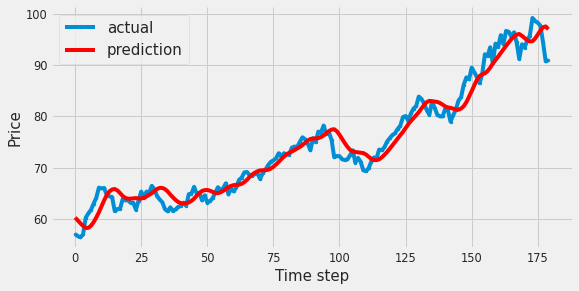

In [25]:
aa=[x for x in range(180)]
plt.figure(figsize=(8,4))
plt.plot(aa, Y_test[0][:180], marker='.', label="actual")
plt.plot(aa, test_predict[:,0][:180], 'r', label="prediction")
plt.tight_layout()
sns.despine(top=True)
plt.subplots_adjust(left=0.07)
plt.ylabel('Price', size=15)
plt.xlabel('Time step', size=15)
plt.legend(fontsize=15)
plt.show();

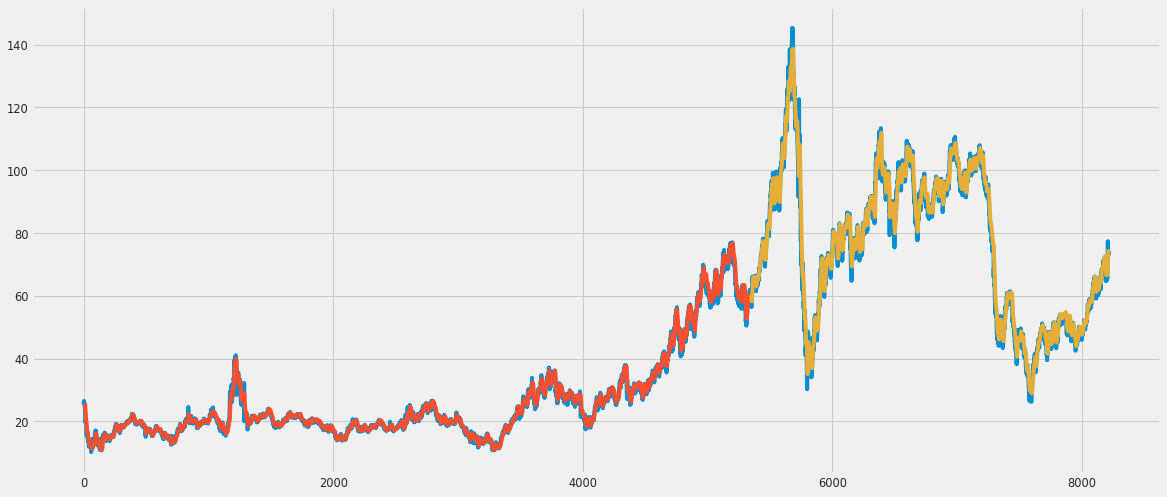

In [26]:
#test the model
look_back = 10
trainPredictPlot = np.empty_like(data_oil)
trainPredictPlot[:,:] = np.nan
trainPredictPlot[look_back:len(train_predict)+look_back,:] = train_predict

testPredictPlot = np.empty_like(data_oil)
testPredictPlot[:,:] = np.nan
testPredictPlot[len(train_predict)+(look_back*2)+1:len(data_oil)-1,:] = test_predict

plt.plot(sc.inverse_transform(data_oil))
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.show()

In [27]:
len(test)

2876

In [32]:
x_input = test[2866:].reshape(1,-1)
x_input.shape

(1, 10)

In [33]:
temp_input = list(x_input[0])
temp_list = temp_input[0].tolist()

In [34]:
temp_input

[0.44172960165852215,
 0.48111950244335855,
 0.49726047682511476,
 0.4679401747371539,
 0.4729749740855915,
 0.47119798608026064,
 0.47341922108692425,
 0.4649785280616022,
 0.4703835332444839,
 0.47149415074781587]

In [35]:
lst_output = []
n_steps = 10
i = 0

In [36]:
while(i<10):
  if(len(temp_input) > 10):
    x_input = np.array(temp_input[1:])
    print("{} day input {}".format(i,x_input),end="\n")
    x_input = x_input.reshape(1,-1)
    x_input = x_input.reshape((1,n_steps,1))

    yhat = regressor.predict(x_input,verbose=0)
    print("{} day output {}".format(i,yhat),end="\n")
    temp_input.extend(yhat[0].tolist())
    temp_input = temp_input[1:]
    print("------------------------",end="\n")
    lst_output.extend(yhat.tolist())
    i = i+1
  else:
    x_input = x_input.reshape((1,n_steps,1))
    yhat = regressor.predict(x_input,verbose=0)
    print("{} day output {}".format(i,yhat),end="\n")
    temp_input.extend(yhat[0].tolist())
    lst_output.extend(yhat.tolist())
    i = i+1

0 day output [[0.47814104]]
1 day input [0.4811195  0.49726048 0.46794017 0.47297497 0.47119799 0.47341922
 0.46497853 0.47038353 0.47149415 0.47814104]
1 day output [[0.47829878]]
------------------------
2 day input [0.49726048 0.46794017 0.47297497 0.47119799 0.47341922 0.46497853
 0.47038353 0.47149415 0.47814104 0.47829878]
2 day output [[0.47898063]]
------------------------
3 day input [0.46794017 0.47297497 0.47119799 0.47341922 0.46497853 0.47038353
 0.47149415 0.47814104 0.47829878 0.47898063]
3 day output [[0.48020533]]
------------------------
4 day input [0.47297497 0.47119799 0.47341922 0.46497853 0.47038353 0.47149415
 0.47814104 0.47829878 0.47898063 0.48020533]
4 day output [[0.48179677]]
------------------------
5 day input [0.47119799 0.47341922 0.46497853 0.47038353 0.47149415 0.47814104
 0.47829878 0.47898063 0.48020533 0.48179677]
5 day output [[0.4833953]]
------------------------
6 day input [0.47341922 0.46497853 0.47038353 0.47149415 0.47814104 0.47829878
 0.4

In [37]:
day_new = np.arange(1,11)
day_pred = np.arange(11,21)
len(data_oil)

print(day_new)
print(day_pred)

[ 1  2  3  4  5  6  7  8  9 10]
[11 12 13 14 15 16 17 18 19 20]


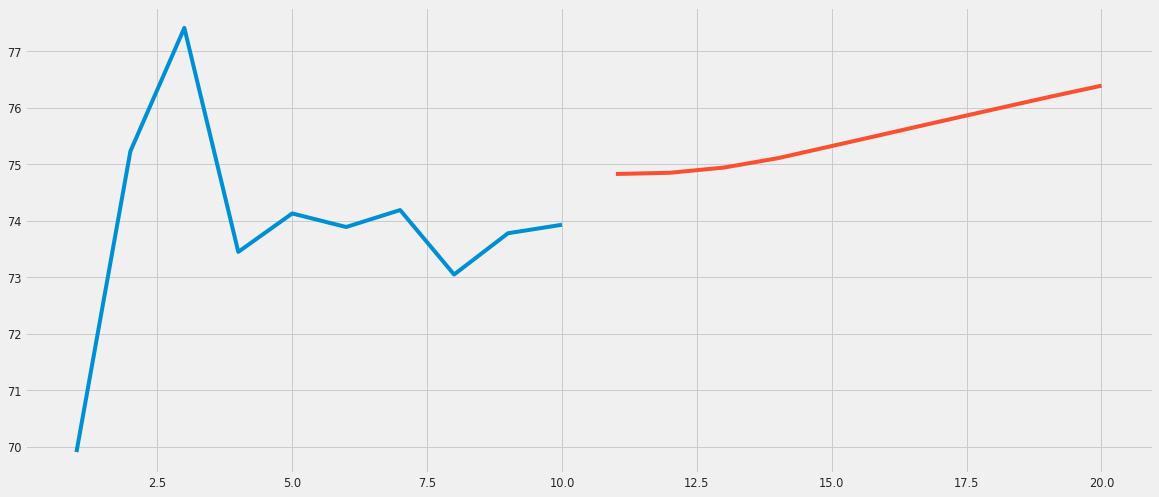

In [39]:
plt.plot(day_new,sc.inverse_transform(data_oil[8206:]))
plt.plot(day_pred,sc.inverse_transform(lst_output))